In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
VOCAB_SIZE = 2500

TOKEN_SPAM_PROB_FILE = 'spam-data/token-spam-prob.txt'
TOKEN_HAM_PROB_FILE = 'spam-data/token-ham-prob.txt'
TOKEN_OVERALL_PROB_FILE = 'spam-data/token-overall-prob.txt'

TEST_FEATURE_MATRIX = 'spam-data/test-features.txt'
TEST_TARGET_FILE = 'spam-data/test-target.txt'

## *Load data*

In [3]:
X_test = np.loadtxt(TEST_FEATURE_MATRIX, delimiter=' ') # features
y_test = np.loadtxt(TEST_TARGET_FILE, delimiter=' ') # target

# probabilities
prob_token_spam = np.loadtxt(TOKEN_SPAM_PROB_FILE, delimiter=' ')
prob_token_ham = np.loadtxt(TOKEN_HAM_PROB_FILE, delimiter=' ')
prob_token_overall = np.loadtxt(TOKEN_OVERALL_PROB_FILE, delimiter=' ')

---
## *Bayes formula:*
## $P(Spam \, | \, X) = \frac{P(X \, | \, Spam) \, P (Spam)}{P(X)}$

In [4]:
# set the prior (prior is a initial 'guess' based on prior knowledge)
PRIOR_PROB_SPAM = 0.3116 # calculated in the training_model notebook
# convert probabilities to log values (simplifies calculation (avoid multiplications and division) and spread the values for better visualizaton)
np.log(prob_token_spam)

array([ -4.43156992,  -5.25657795,  -4.95782974, ..., -11.48212599,
        -9.23083419, -11.07666089])

## *Joint probability (Spam and Ham)*
### *using the dot product (multiply the whole X_test array by the probabilities)*

In [5]:
# spam
print(np.where(prob_token_overall==0)[0]) # index which contains the value 0 (causing problems to apply log)
prob_token_overall[872] = 0.00000000001 # make it nonzero
joint_log_spam = X_test.dot(np.log(prob_token_spam) - np.log(prob_token_overall)) + np.log(PRIOR_PROB_SPAM)
joint_log_spam[:5]

[872]


array([ -7.08377979,  -0.38828262, -53.7297659 ,   6.83221631,
        -2.67213445])

In [6]:
#ham > P(Ham) = 1 - P(Spam)
joint_log_ham = X_test.dot(np.log(prob_token_ham) - np.log(prob_token_overall)) + np.log(1 - PRIOR_PROB_SPAM)
joint_log_ham[:5]

array([ -1.66619644,  -3.01136782,  -5.48219505, -22.98376209,
        -4.63684008])

#### Obs: *It's possible to remove the (- np.log(prob_token_overall)) from the calculation of both joint probabilities without affecting the result of the prediction below. This part of the expression is equivalent to the division by P(X) in the bayes formula, however, we're dealing with logs so it turns into a subtraction. It's a possible simplification*

---

## Making predictions using the joint probability:
#### $P(Spam \, | \, X) > P(Ham \, | \, X)$
####   **OR**
#### $P(Spam \, | \, X) < P(Ham \, | \, X)$

In [7]:
# true == spam; false == nonspam
predictions = joint_log_spam > joint_log_ham
predictions[:5]

array([False,  True, False,  True,  True])

---
### *Check the accuracy*

In [8]:
correct_docs = (y_test == predictions).sum()
print('Documents classified correctly:', correct_docs)
incorrect_docs = (X_test.shape[0] - correct_docs)
print('Documents classified incorrectly:', incorrect_docs)

#accuracy
accuracy = correct_docs/len(X_test)
print('Accuracy: {:.2%}'.format(accuracy))

Documents classified correctly: 1677
Documents classified incorrectly: 44
Accuracy: 97.44%


---

## *Results visualization*
#### *(the decision boundary)*

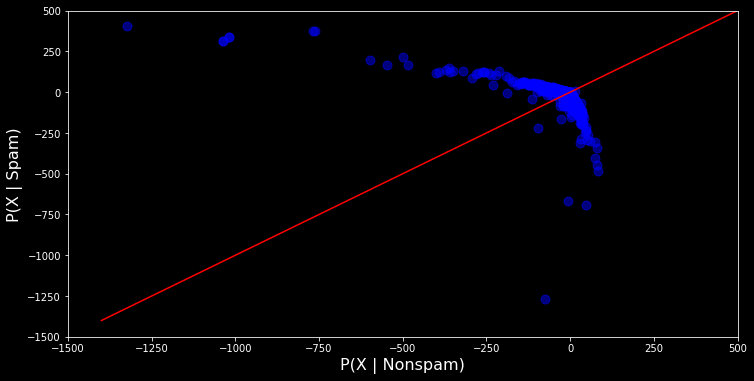

In [9]:
yaxis_label = 'P(X | Spam)'
xaxis_label = 'P(X | Nonspam)'
# create a line
linedata = np.linspace(start=-1400, stop=500, num=1000)

plt.style.use('dark_background')

plt.figure(figsize=(12, 6))
plt.xlabel(xaxis_label, fontsize=16)
plt.ylabel(yaxis_label, fontsize=16)

# scale
plt.xlim([-1500, 500])
plt.ylim([-1500, 500])

plt.scatter(joint_log_ham, joint_log_spam, color='blue', alpha=0.5, s=80)
plt.plot(linedata, linedata, color='red')
plt.show()

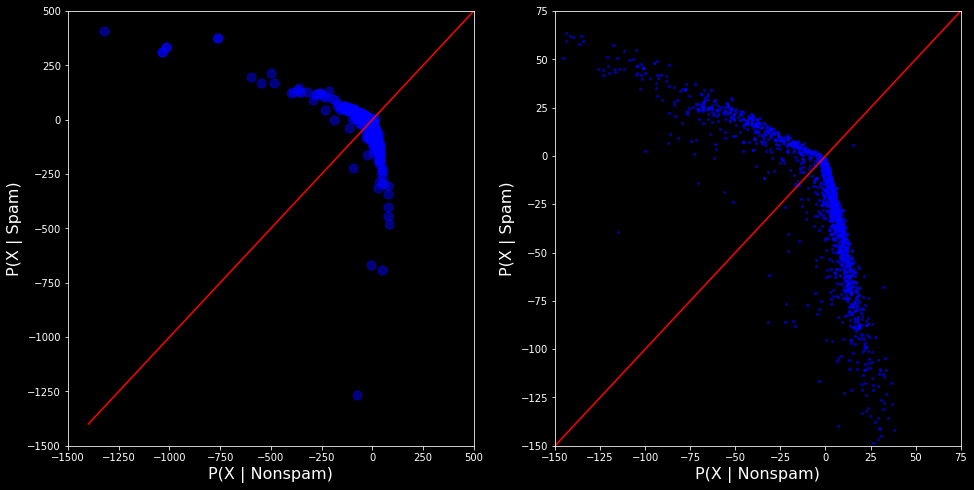

In [10]:
# ZOOM IN

plt.figure(figsize=(16, 8))
# Chart 1
plt.subplot(1, 2, 1)
plt.xlabel(xaxis_label, fontsize=16)
plt.ylabel(yaxis_label, fontsize=16)
# scale
plt.xlim([-1500, 500])
plt.ylim([-1500, 500])
# plot
plt.scatter(joint_log_ham, joint_log_spam, color='blue', alpha=0.5, s=80)
plt.plot(linedata, linedata, color='red')

# Chart 2
plt.subplot(1, 2, 2)
plt.xlabel(xaxis_label, fontsize=16)
plt.ylabel(yaxis_label, fontsize=16)
# scale
plt.xlim([-150, 75])
plt.ylim([-150, 75])
# plot
plt.scatter(joint_log_ham, joint_log_spam, color='blue', alpha=0.5, s=5)
plt.plot(linedata, linedata, color='red')

plt.show()

##### *Using seaborn:*

In [11]:
# style
sns.set_style('darkgrid')
labels = 'Real category'
# Put the information in a dataframe (better for sns)
info_df = pd.DataFrame({ yaxis_label: joint_log_spam, xaxis_label: joint_log_ham, labels: y_test })

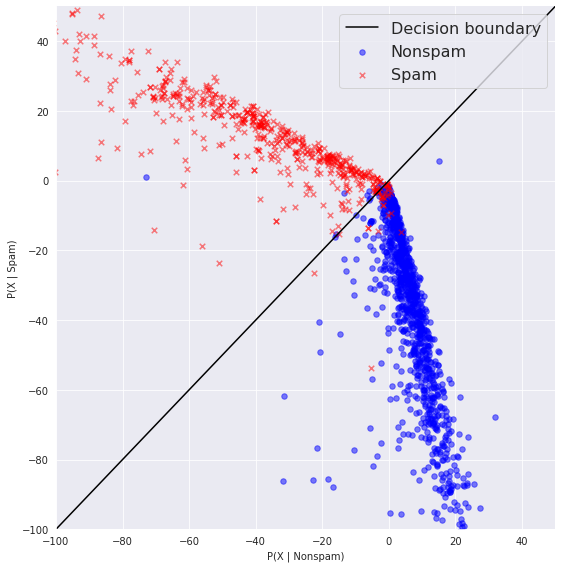

In [12]:
# plot
sns.lmplot(x=xaxis_label, y=yaxis_label,
           data=info_df, height=8, fit_reg=False, legend=False,
           scatter_kws={'alpha': 0.5, 's': 30}, 
           hue=labels, markers=['o', 'x'], palette=['blue', 'red'])
plt.xlim([-100, 50])
plt.ylim([-100, 50])
plt.plot(linedata, linedata, color='black')
plt.legend(('Decision boundary', 'Nonspam', 'Spam'), loc='upper right', fontsize='16')

plt.show()

---

### *False Positives*
#### *and*
### *False Negatives:*

In [13]:
print(np.unique(predictions, return_counts=True));
print('Nonspam predictions:', np.unique(predictions, return_counts=True)[1][0])
print('Spam predictions:', np.unique(predictions, return_counts=True)[1][1])

(array([False,  True]), array([1153,  568]))
Nonspam predictions: 1153
Spam predictions: 568


In [14]:
# actual amount of nonspam
true_negatives = (y_test == 0) & (predictions == 0)
print('True nonspam number:', true_negatives.sum())
# actual amount of spam
true_positives = (y_test == 1) & (predictions == 1) # bitwise &
print('True spam number:', true_positives.sum())

True nonspam number: 1122
True spam number: 555


In [15]:
false_negatives = (y_test == 1) & (predictions == 0)
print('False negatives:', false_negatives.sum())
false_positives = (y_test == 0) & (predictions == 1)
print('False positives:', false_positives.sum())

False negatives: 31
False positives: 13


---

### *Recall and precision scores:*

In [16]:
recall_score = (true_positives.sum()) / (true_positives.sum() + false_negatives.sum())
print('Recall score: {:.2%}'.format(recall_score))

Recall score: 94.71%


In [17]:
precision_score = (true_positives.sum()) / (true_positives.sum() + false_positives.sum())
print('Precision: {:.2%}'.format(precision_score))

Precision: 97.71%


### *F-Measure:*
##### *The f-measure is the harmonic average of precision and recall. Because of that, it takes into account both false positives and false negatives*

In [18]:
f_score = 2 * ((recall_score * precision_score) / (recall_score + precision_score))
print('F-Measure: {:.2%}'.format(f_score))

F-Measure: 96.19%


---